In [15]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

unpickled_df1 = pd.read_pickle("pickle_data\df1gram_sorted.pickle.gzip")
unpickled_df2 = pd.read_pickle("pickle_data/2gram/2_20000_nopos_ab.gz")
df1gram = unpickled_df1
df2gram = unpickled_df2
print(unpickled_df1)



                1900   1901   1902   1903   1904   1905   1906   1907   1908  \
Empfehlungen    2772   2418   2466   2939   3010   2945   3344   3636   3354   
Fachbereich       18      5      0      5      0      1      1      5      7   
Besprechungen   9201  10329  11539  11474  12928  12706  14154  13283  14325   
Berechtigung   36992  41263  43328  44095  47043  50863  54312  54353  55122   
Beiträgen      11657  12092  13215  12741  14330  14318  17206  15555  16436   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
geistig        16840  19841  20536  21125  25894  25610  28848  27045  29084   
einsetzte       2917   3296   3551   4132   4378   4915   5354   5703   6062   
fasziniert        36     43     48     71    134    203    215    262    243   
fährt          19865  19755  21965  22859  23231  24609  25505  26038  28560   
jeweiligen     17833  20031  20835  21655  23959  24925  28730  28865  29898   

                1909  ...    2010    20

In [16]:
print(unpickled_df2)

                          1900    1901    1902    1903    1904    1905  \
sich die                528087  544734  578760  590685  656660  666176   
sind ,                  784877  821705  876721  869331  960784  981197   
sich in                 497332  517702  543047  553958  619577  621924   
sind .                  580979  604451  648669  648513  732061  744763   
sie sich                251882  258046  272807  283145  305572  310690   
...                        ...     ...     ...     ...     ...     ...   
Eigenthum wiederholt         0       0       0       0       0       0   
Blüthen eingeschlossen       0       0       0       0       0       0   
nöthigen neueren             0       0       0       0       0       0   
theils entzündet             0       0       0       0       0       0   
nämliche Niederschlag        0       0       0       0       0       0   

                           1906     1907     1908    1909  ...     2010  \
sich die                 724462   73

Find lower level ngrams

In [17]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   first = first + ''.join(middle)
   last = ''.join(middle) + last
   return first, last

MLR approach

In [18]:
def MLR(token):
    first,last = getLowerLevelString(token)
    X = pd.concat([df1gram.loc[first],df1gram.loc[last]],axis=1)
    y = df2gram.loc[token]
    reg = LinearRegression()
    reg.fit(X, y) 
    
    return reg.coef_,reg.intercept_,X

Build approximation on the whole dataset

In [19]:
def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

Compress whole 2gram data with error parameter

In [20]:
def compressWithError2gram(firstN,error):
    df_N_2gram = df2gram.head(firstN)
    
    result = []
    all = []
    sum = []
    for ngram in df_N_2gram.index.values:
        coef,intercept,dfAprox = MLR(ngram)
        c1,c2 = coef
        df = buildApproximation(c1,c2,intercept,dfAprox)
        dfOriginal = pd.DataFrame()
        dfOriginal['values'] = df2gram.loc[ngram]
        dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
        #dfOriginal= pd.to_numeric(dfOriginal)
        dfOriginal['zscore'] = zscore(dfOriginal)
        df['zscore'] = zscore(df['approximation'])
        
        sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
        
        rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
        #rmse = mean_squared_error(dfOriginal, df['approximation'])
        if rmse <= error:
            result.append([ngram,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
        all.append(rmse)    
    return result, all, sum

In [22]:
result, all, sum = compressWithError2gram(100000,0.05)
print(len(result))

792


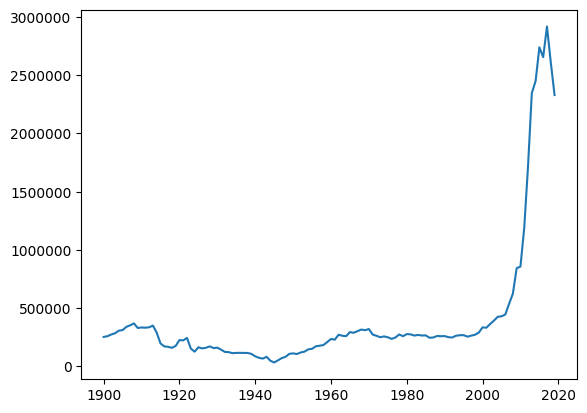

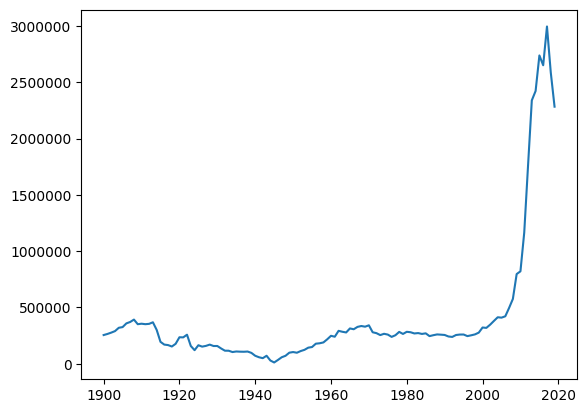

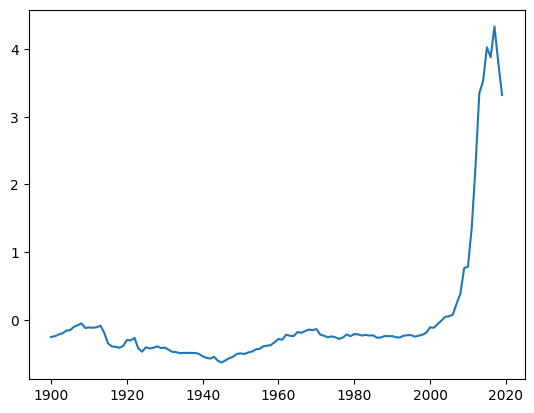

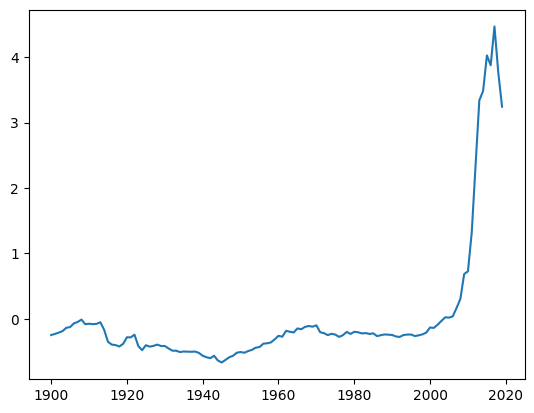

0.029099394327714335
sie sich


In [23]:
graph = 1

plt.ticklabel_format(style = 'plain')
result[graph][2].plot()
plt.show()
plt.ticklabel_format(style = 'plain')
result[graph][4].plot()
plt.show()
result[graph][3].plot()
plt.show()
result[graph][5].plot()
plt.show()

print(result[graph][1])
print(result[graph][0])

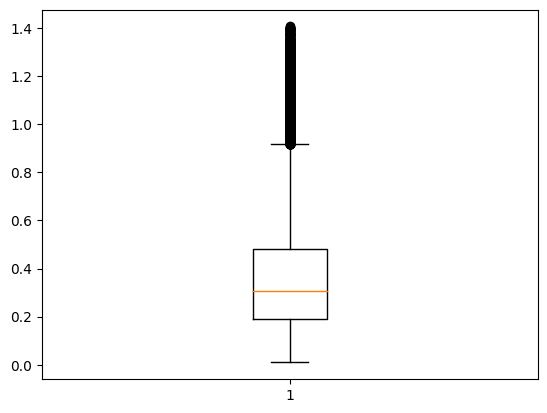

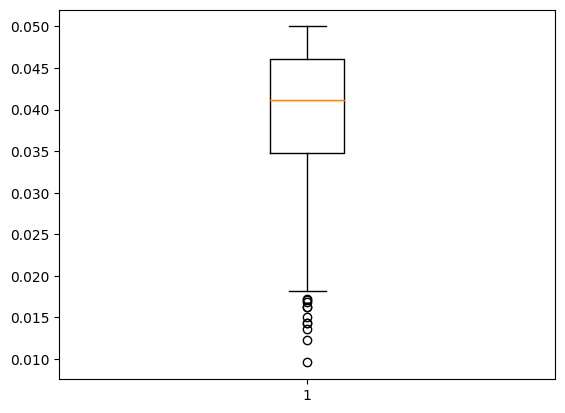

<AxesSubplot: >

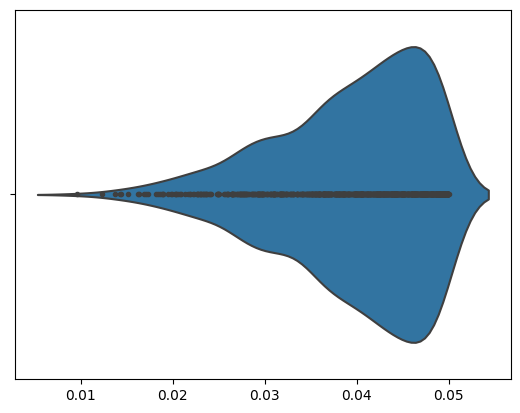

In [24]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")


<AxesSubplot: >

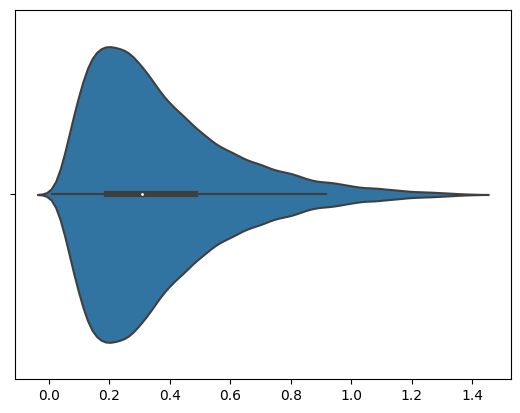

In [25]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

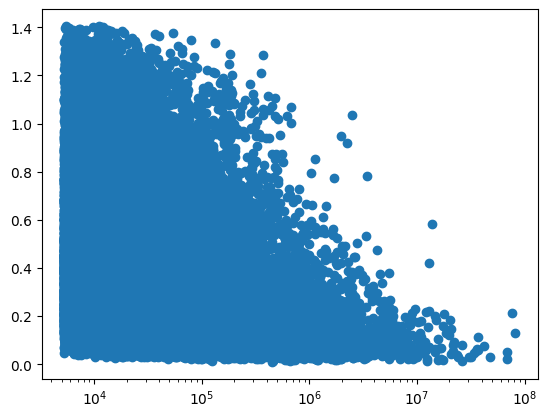

In [29]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()